# Sampling and Filtering Example

Adapted by AJ Cuddeback from a notebook written by Peter Mathys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy.polynomial.polynomial as npp

In [14]:
#cell contents by Peter Mathys
#%matplotlib notebook #change this for interactivity
fsz = (6,4)
fsz2 = (fsz[0], 1.2*fsz[1]/2.0)

# Parameters
Fs = 8000
tlen = 1
tt = np.arange(round(tlen*Fs))/float(Fs)-tlen/2.0
ix0 = np.argmin(np.abs(tt))
fL = 1000

In [3]:
def FTapprox(tt, xt, thr=1e-6, deg=1, swapt=1, swapf=1):
    """
    Compute FFT approximation to FT
    with frequency and time shift/swap
    and with threshold for phase suppression
    returns ff [Hz], absXf, argXf [rad] or [deg] for deg=0 or 1
    returns |Xf| in dB with lower limit thr if thr<0
    swapt=0 -> do not swap pos/neg t
    swapf=0 -> do not swap pos/neg f
    
    EDIT TO MATHY'S CODE MADE 11/27 by AJ Cuddeback
    - changed parameter from t to tt to make function use parameter
    - added Xf as output to be used for inverse FFT
    """
    N = tt.size 
    Fs = (N-1)/(tt[-1]-tt[0])   # extract sampling rate
    if swapt:             # swap pos/neg times (if any)
        ixp = np.where(tt>=0)
        ixn = np.where(tt<0)
        xt = np.hstack((xt[ixp], xt[ixn]))   # swap pos/neg time axes
    Df = Fs/float(N)      # frequency resolution
    f = Df*np.arange(N)   # frequency axis
    Xf = np.fft.fft(xt)/float(Fs)    # FT approximation
    if swapf:             # swap pos/neg frequencies
        ixp = np.where(f<Fs/2.0)
        ixn = np.where(f>=Fs/2.0)
        f = np.hstack((f[ixn]-Fs, f[ixp]))
        Xf = np.hstack((Xf[ixn], Xf[ixp]))
    absXf = np.abs(Xf)
    argXf = np.zeros(Xf.size)
    if thr<0:
        linthr = 10**(thr/20.0)  # linear lower threshold
        absXfdB = linthr*np.ones(absXf.size)   # set lower linit
        ix = np.where(absXf>=linthr)  # indexes where absXf>=linthr
        absXfdB[ix] = absXf[ix]
        absXf = 20*np.log10(absXfdB)
    else:
        ix = np.where(absXf>=thr)
    argXf[ix] = np.angle(Xf[ix])
    if deg:
        argXf = 180/np.pi*argXf
    return f, Xf, absXf, argXf        

In [4]:
def p_sinc(t,k):
    """
    Author: Peter Mathys
    sinc function, truncated to k zero crossings
    """
    pt = np.zeros(len(t))
    ix = np.where(np.logical_and(t>=-k,t<k))
    pt[ix] = np.sinc(t[ix])
    return pt

In [5]:
def filtFIR(xt, ht, Fs):
    """
    Author: Peter Mathys
    Delay compensated pseudo CT FIR filter with impulse response ht
    """
    N = len(ht)-1   # filter order
    N2 = int(round(N/2.0))   # half of filter length
    yt = ss.lfilter(ht, 1, np.hstack((xt, np.zeros(N2))))/float(Fs)
    return yt[N2:]

In [6]:
def ideaLPF(xt, Fs, fL, k=10):
    """
    Author: Peter Mathys
    "Ideal LPF" based on truncated (to t=k/(2*fL)) sinc h(t)
    """
    ix = round(k*Fs/(2*fL))
    t = np.arange(-ix,ix)/float(Fs)  # time axis
    ht = 2*fL*np.sinc(2*fL*t)        # impulse response
    yt = filtFIR(xt, ht, Fs)         # delay-compensated filtering
    return yt

In [56]:
fftplot_sz = (18, 6)
def get_and_plot_FFT(tt, xt, xlim_low, xlim_high, plot=True):
    """
    Author: AJ Cuddeback, functionalization of code by Peter Mathys
    Calculate the fft of a transient signal and plot if plot=True (default is True)
    xlim_low and xlim_high are the low and high frequency bounds for the FFT plot
    
    """
    ff, Xf, absXf, argXf = FTapprox(t_cont, sampled_signal)
    if(plot==True):
        f1=xlim_low; f2=xlim_high;
        plt.figure(figsize=fftplot_sz); plt.subplot(211)
        plt.plot(ff, absXf, '-b')
        plt.title(' Frequency Response')
        plt.ylabel('$|H(f)|$'); plt.grid(); plt.xlim([f1,f2])
        plt.subplot(212)
        plt.plot(ff, argXf, '-r')
        plt.ylabel('$\\angle H(f)$ [deg]');plt.xlabel('$f$ [Hz]')
        plt.grid();plt.xlim([f1,f2]);plt.tight_layout()
        plt.show()
    return ff, Xf, absXf, argXf

# Sampling Example Section Setup

In [57]:
# Global Variables
T_cos = 16
points_per_second = 1000 # defines time resolution for continuous signal
n_cycles = 4; tstart = -round(n_cycles*T_cos/2); tstop = round(n_cycles*T_cos/2)
t_cont = np.linspace(tstart, tstop, round(n_cycles*T_cos*points_per_second)+1) # 1000 time points per cycle
def f(_t):
    return np.cos(2*np.pi*(1/T_cos)*_t) # T_cos is set to 16 as a global variable
continuous_signal = f(t_cont)

In [58]:
# Function Definitions
def make_impulse_train(_t, _nT, _tshift):
    """
    takes a continuous time array and an array of time offsets for an impulse train
    
    Written by AJ Cuddeback - Last updated 11/27/2022
    """
    impulse_train = np.zeros(_t.shape)
    for nT in _nT:
        impulse_train[np.absolute(_t-nT).argmin()] = 1
    # returns impulse train that is nan at all t except for t=nT, shifted by a value of _tshift (s)
    impulse_train = np.roll(impulse_train, _tshift*points_per_second)
    return impulse_train

def get_plot_sample(continuous_signal, samples_per_cycle, ts):
    """
    Uses global variables t_cont, tstart, tstop, n_cycles
    
    Written by AJ Cuddeback - Last updated 11/27/2022
    """
    plt.figure(figsize=(18,2)); plt.grid(); plt.grid(True, which='both')
    #plt.plot(t_cont, continuous_signal, label="Original Signal", color='C0')
    nT = np.linspace(tstart, tstop, (n_cycles*samples_per_cycle)+1); # array of times for impulse train
    impulse_train = make_impulse_train(t_cont, nT, ts)
    sampled_signal = np.multiply(continuous_signal, impulse_train)
    titlestr = "Digital Sample with " + str(samples_per_cycle) + " Samples Per Cycle and a Tshift of " + str(ts) + "s"
    plt.scatter(t_cont, sampled_signal)
    plt.ylabel("Signal, V (Volts)"); plt.title(titlestr)
    plt.xlabel("Time, t (s)")
    plt.show()
    return sampled_signal

# Digital Sampling Example Setup
Recall the continuous time signal $f(t) = cos(\frac{2\pi t}{T})$ with a period of T = 16

The code below plots this function as a pseudo-continuous signal.

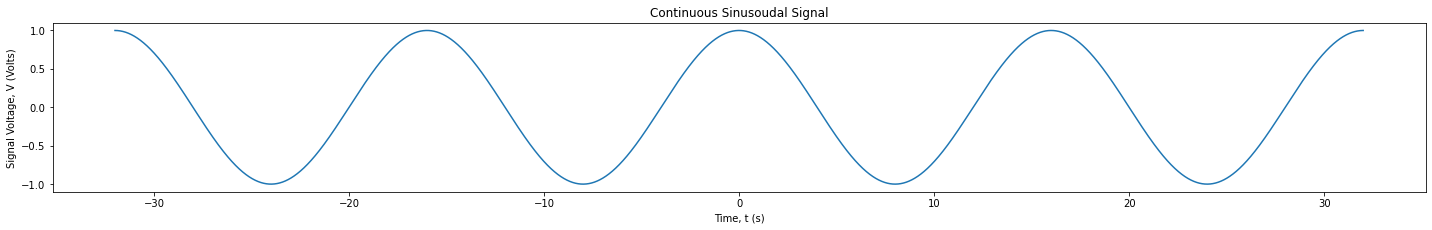

In [59]:
plt.figure(figsize=(20,3.3));
plt.plot(t_cont, continuous_signal, label="Continuous Time Signal", color='C0')
plt.xlabel("Time, t (s)"); plt.ylabel("Signal Voltage, V (Volts)")
plt.title("Continuous Sinusoudal Signal");plt.tight_layout();plt.show()

# Exercise: Getting the FFT of our Sampled Signal

Now let's see what happens when we sample our signal, take the FFT, and then convert back to continuous time. Run the code below with several different values for samples_per_cycle, all greater than 50. Answer the following questions and provide plots to support your answers:
- Is there a relationship between the temporal resolution of the pseudo-continuous signal and the domain of the FFT? 
- How does the sampling rate affect the shape of the FFT?
- How does the sampling rate affect the shape of the inverse FFT?

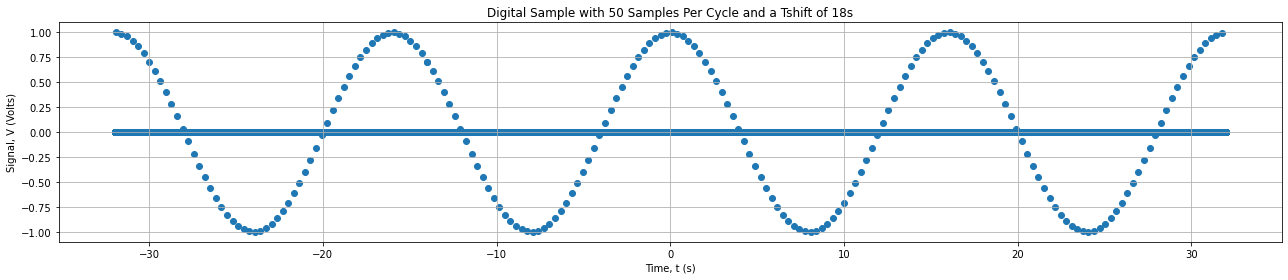

In [62]:
#Set up the signal 
ts = 18
samples_per_cycle = 50 # Change this to see how it changes the output

plt.figure(figsize=(18,4)); plt.grid(); plt.grid(True, which='both')
#plt.plot(t_cont, continuous_signal, label="Original Signal", color='C0')
nT = np.linspace(tstart, tstop, (n_cycles*samples_per_cycle)+1); # array of times for impulse train
impulse_train = make_impulse_train(t_cont, nT, ts)
sampled_signal = np.multiply(continuous_signal, impulse_train)
titlestr = "Digital Sample with " + str(samples_per_cycle) + " Samples Per Cycle and a Tshift of " + str(ts) + "s"
plt.scatter(t_cont, sampled_signal)
plt.ylabel("Signal, V (Volts)"); plt.title(titlestr);plt.tight_layout()
plt.xlabel("Time, t (s)");plt.tight_layout()
plt.show()

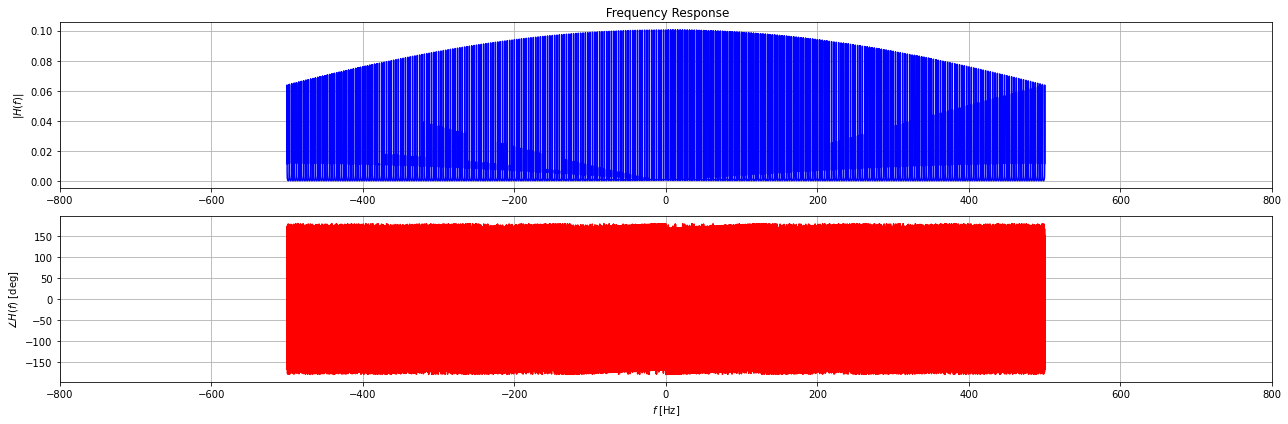

In [63]:
# sampled_signal = get_plot_sample(continuous_signal, samples_per_cycle, ts)

# Frequency response
ff, Xf, absXf, argXf = get_and_plot_FFT(t_cont, sampled_signal, -800, 800)

# Plotting Inverse FFT - Needs Input
I'm not really sure why the inverse FFT looks so wrong nor why the FFT looks so wrong. Is it because of the 0 values in the sampled signal?

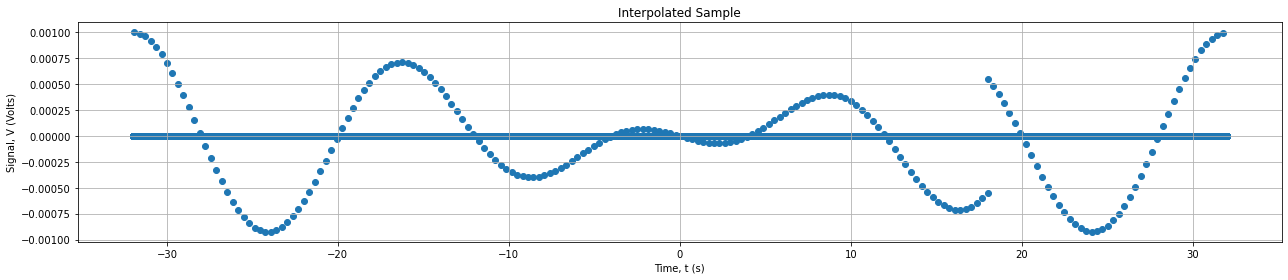

In [64]:
# Inverse Fourier
s = np.fft.ifft(Xf)
plt.figure(figsize=(18,4)); plt.grid(); plt.grid(True, which='both')
plt.scatter(t_cont, s.real)
plt.xlabel("Time, t (s)");plt.tight_layout()
plt.ylabel("Signal, V (Volts)"); 
plt.title("Interpolated Sample");plt.tight_layout()
plt.show()

# Original Notebook Contents by Peter Mathys
Included for reference / validation of function performance

In [65]:
# Parameters
Fs = 8000
tlen = 1
tt = np.arange(round(tlen*Fs))/float(Fs)-tlen/2.0
ix0 = np.argmin(np.abs(tt))
fL = 1000
#print(tt[0],tt[-1],tt[ix0])

In [ ]:
# Unit impulse response
#k = 2
k = 10
deltat = np.zeros(tt.size)
deltat[ix0] = Fs    # "pseudo CT" unit impulse
ht = ideaLPF(deltat, Fs, fL, k)
plt.figure(3, figsize=fsz2)
plt.plot(tt, ht, '-b')
plt.title('IdeaLPF, Impulse Response, $f_L$={}, $k$={}'.format(fL, k))
plt.ylabel('$h(t)$')
plt.xlabel('$t$ [sec]')
plt.grid()
plt.xlim([-0.01,0.01])
plt.tight_layout()

In [ ]:
# Frequency response
ff, Hf, absHf, argHf = FTapprox(tt, ht, thr=1e-6, deg=1, swapt=1, swapf=1)
f1=-2000; f2=2000;
#f1=-500; f2=500;
#f1=-50; f2=50;
plt.figure(7, figsize=fsz)
plt.subplot(211)
plt.plot(ff, absHf, '-b')
plt.title('IdeaLPF, Frequency Response, $f_L$={}, $k$={}'.format(fL, k))
plt.ylabel('$|H(f)|$')
plt.grid()
plt.xlim([f1,f2])
plt.subplot(212)
plt.plot(ff, argHf, '-r')
plt.ylabel('$\\angle H(f)$ [deg]')
plt.xlabel('$f$ [Hz]')
plt.grid()
plt.xlim([f1,f2])
plt.tight_layout()

In [ ]:
# Frequency response
ff, Hf, absHf, argHf = FTapprox(tt, ht, thr=-60, deg=1, swapt=1, swapf=1)
f1=-2000; f2=2000;
#f1=-500; f2=500;
#f1=-50; f2=50;
plt.figure(11, figsize=fsz)
plt.subplot(211)
plt.plot(ff, absHf, '-b')
plt.title('IdeaLPF, Frequency Response, $f_L$={}, $k$={}'.format(fL, k))
plt.ylabel('$|H(f)|$ [dB]')
plt.grid()
plt.xlim([f1,f2])
plt.subplot(212)
plt.plot(ff, argHf, '-r')
plt.ylabel('$\\angle H(f)$ [deg]')
plt.xlabel('$f$ [Hz]')
plt.grid()
plt.xlim([f1,f2])
plt.tight_layout()

In [ ]:
# (Pole) zero plot of h(t)
htr = ht[-1::-1]
htroots = npp.polyroots(htr)    # numerator roots (zeros)
cir = np.exp(2j*np.pi*np.arange(360)/360.0)
plt.figure(15, figsize=fsz)
plt.plot(np.real(cir),np.imag(cir),'--k')
plt.plot(np.real(htroots),np.imag(htroots),'ob')
plt.title('(Poles,) Zeros, $H(z)$')
plt.grid()
plt.axis('equal')
plt.axis('square')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.tight_layout()